# Mean-Variance Sig Trading

### Underlying Process: 1-dimensional BM process

This notebook demonstrates some basic usage of the Sig-Trading framework for mean-variance optimisation.
1. Implementation in PyTorch / signatory
2. Implementation in Numpy / iisignature

Whichever method is preferred due to computational speed and device type. PyTorch method allows for cuda/GPU computation.

In [1]:
import notebook_base

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from mean_variance.utils import *
from mean_variance.simulators import *
from mean_variance.sig_trader import *
from data.path import Path

## 1. Implementation in PyTorch

In [2]:
if torch.cuda.is_available(): 
  device = 'cuda'
else: 
  device = 'cpu'

print('device:', device)

device: cuda


### Create BM Data

In [3]:
torch.manual_seed(8)

N = 1000

paths = generate_gbm(
    n_samples=2*N,
    n_days=200,
    mu=0.001,
    vol=0.01,
    dt=1, 
    dim=1)

train_paths = torch.log(paths[:N])
test_paths = torch.log(paths[N:])

In [4]:
def BH_solution(train_paths, risk_aversion):
    mu = train_paths.diff(dim=1).mean(1).mean(0,keepdim=True)
    sigma = train_paths.diff(dim=1).std(1).mean(0,keepdim=True)

    return 1/risk_aversion * torch.inverse(sigma)@mu


In [5]:
all_paths = torch.cat([train_paths, test_paths], dim=-1)

In [6]:
static_pos = BH_solution(train_paths, 0.5)

In [7]:
BH_pnl = (static_pos * test_paths)[:,:,-1]

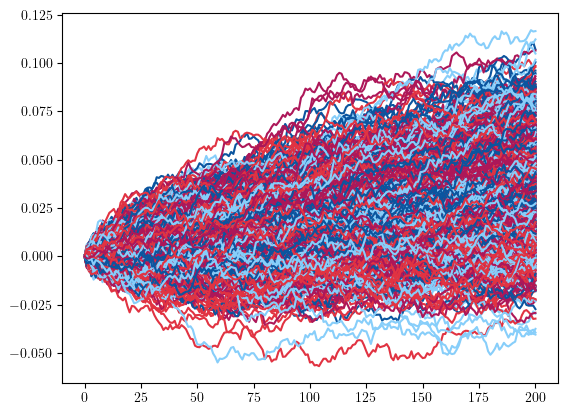

In [8]:
plt.plot(BH_pnl.T);

Variance of static pnl paths

In [9]:
mv = BH_pnl.std().double()**2

### Create, fit & test Sig-Trader

In [10]:
order = 3
ST = SigTrader(order=order)

In [11]:
ST.fit(asset_paths = train_paths, order=order, fast_sol=True, max_var=mv);

In [12]:
position, pnl = ST.compute_pnl(asset_paths = test_paths, order=order)
sample_pos, sample_pnl = ST.compute_pnl(asset_paths = train_paths,  order = order)

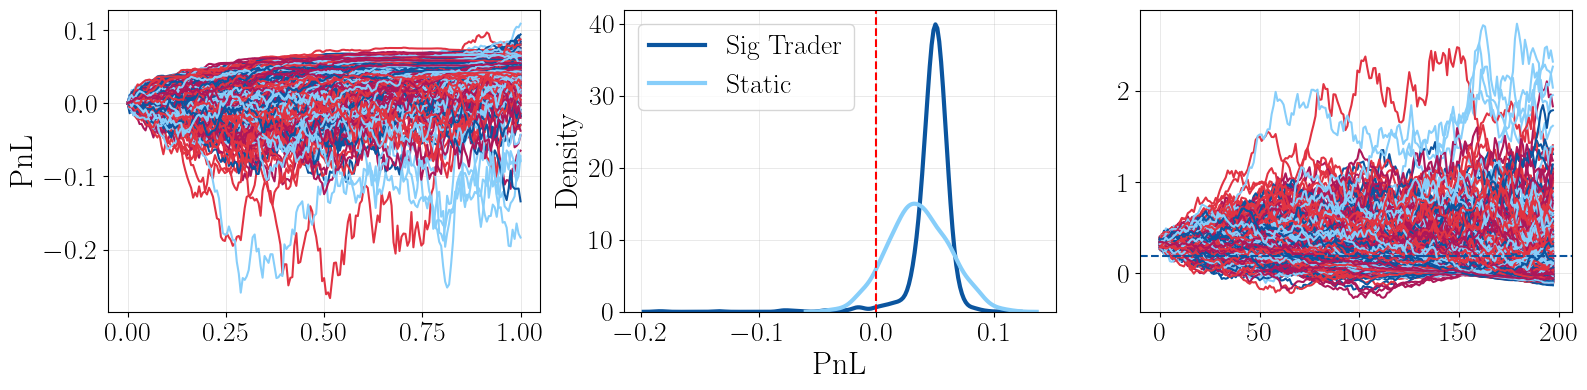

In [13]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(np.linspace(0,1,pnl.shape[-1]), pnl.T);
ax[0].set_ylabel('PnL')

sns.kdeplot(pnl[:,-1], label='Sig Trader',ax = ax[1], lw=3)
sns.kdeplot(BH_pnl[:,-1], label='Static',ax = ax[1], lw=3)
ax[1].legend(fontsize=20)
ax[1].axvline(0, color='r', linestyle='--', label='Zero PnL')
ax[1].set_xlabel('PnL')

ax[2].plot((position[:,:,-1].T) );
ax[2].axhline(y = static_pos[0,0], linestyle="--");


for i in range(3):
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()

### Different Orders

In [14]:
pnls = []
for order in range(1,4):
    ST = SigTrader(order=order)
    ST.fit(asset_paths = train_paths, order=order, fast_sol=True, max_var=mv);
    position, pnl = ST.compute_pnl(asset_paths = test_paths, order=order)
    # sample_pos, sample_pnl = ST.compute_pnl(asset_paths = train_paths,  order = order)
    pnls.append(pnl[:,-1])

pnls = np.stack(pnls)

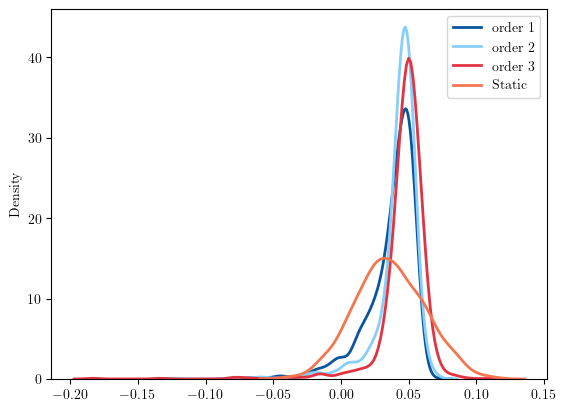

In [31]:
for i in range(3):
    sns.kdeplot(pnls[i], label=f'order {i+1}', lw=2)
sns.kdeplot(BH_pnl[:,-1], label='Static', lw=2, color=sns.color_palette("rocket")[4])
plt.legend()